# Validation Service Benchmarks


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pprint import pprint

### Configuration

In [6]:
metric_options = [
    ("timestamp", "Timestamp MS since Epoch"), #0
    ("CPU_ALL:User%", "CPU Total: User %", [0,100]), # 1
    ("CPU_ALL:Sys%", "CPU Total: System %", [0,100]), # 2
    ("MEM:memtotal", "Memory MB: Total", [0,65000]), #3
    ("MEM:hightotal", "Memory MB: High Total", [0,65000]), #4
    ("MEM:lowtotal", "Memory MB: Low Total", [0,65000]), #5
    ("MEM:swapfree", "Memory MB: Swap Free", [0,1000]), #6
    ("MEM:active", "Memory MB: Active", [0,65000]), #7
    ("MEM:inactive", "Memory MB: Inactive", [0,65000]), #8
    ("NET:eno1-write-KB/s", "Network Write KB/s", [0,1000]), #9
    ("NET:eno1-read-KB/s", "Network Read KB/s", [0,1000]), #10
    ("DISKBUSY:sda", "Disk Busy %: /dev/sda", [0,100]), #11
    ("DISKREAD:sda", "Disk Read KB/s: /dev/sda", [0,10000]), #12
    ("DISKWRITE:sda", "Disk Write KB/s: /dev/sda", [0,10000]), #13
    ("VM:pgfault", "Paging and Virtual Memory: Page Faults", [0,100]) #14
]

possible_experiments = [
    "static_budget/no_budget/read_primary_shard",
    "static_budget/no_budget/read_local_mongod",
    "static_budget/sample_rate/10_percent/read_local_mongod",
    "static_budget/sample_rate/20_percent/read_local_mongod",
    "static_budget/sample_rate/50_percent/read_local_mongod",
    "static_budget/total_limit/20M/read_local_mongod"
]

experiments = [
    "no_budgets/job_mode_multiprocessing",
    "static_budget/sample_rate/50_percent/read_local_mongod",
]

chosen_metric = metric_options[7]
metric_header = chosen_metric[0]
metric_name = chosen_metric[1]
y_axis_limits = chosen_metric[2]

experiment_dfs = []
for experiment in experiments:
    dataframes = []
    for i in range(0, 25):
        machine_id = f"lattice-{150+i}"
        filename = f"{i}-{machine_id}.nmon.csv"
        filepath = f"{experiment}/{filename}"
        dataframes.append(pd.read_csv(filepath, header=0).pop(metric_header))
    experiment_dfs.append((experiment, dataframes))


### Cluster Plotting

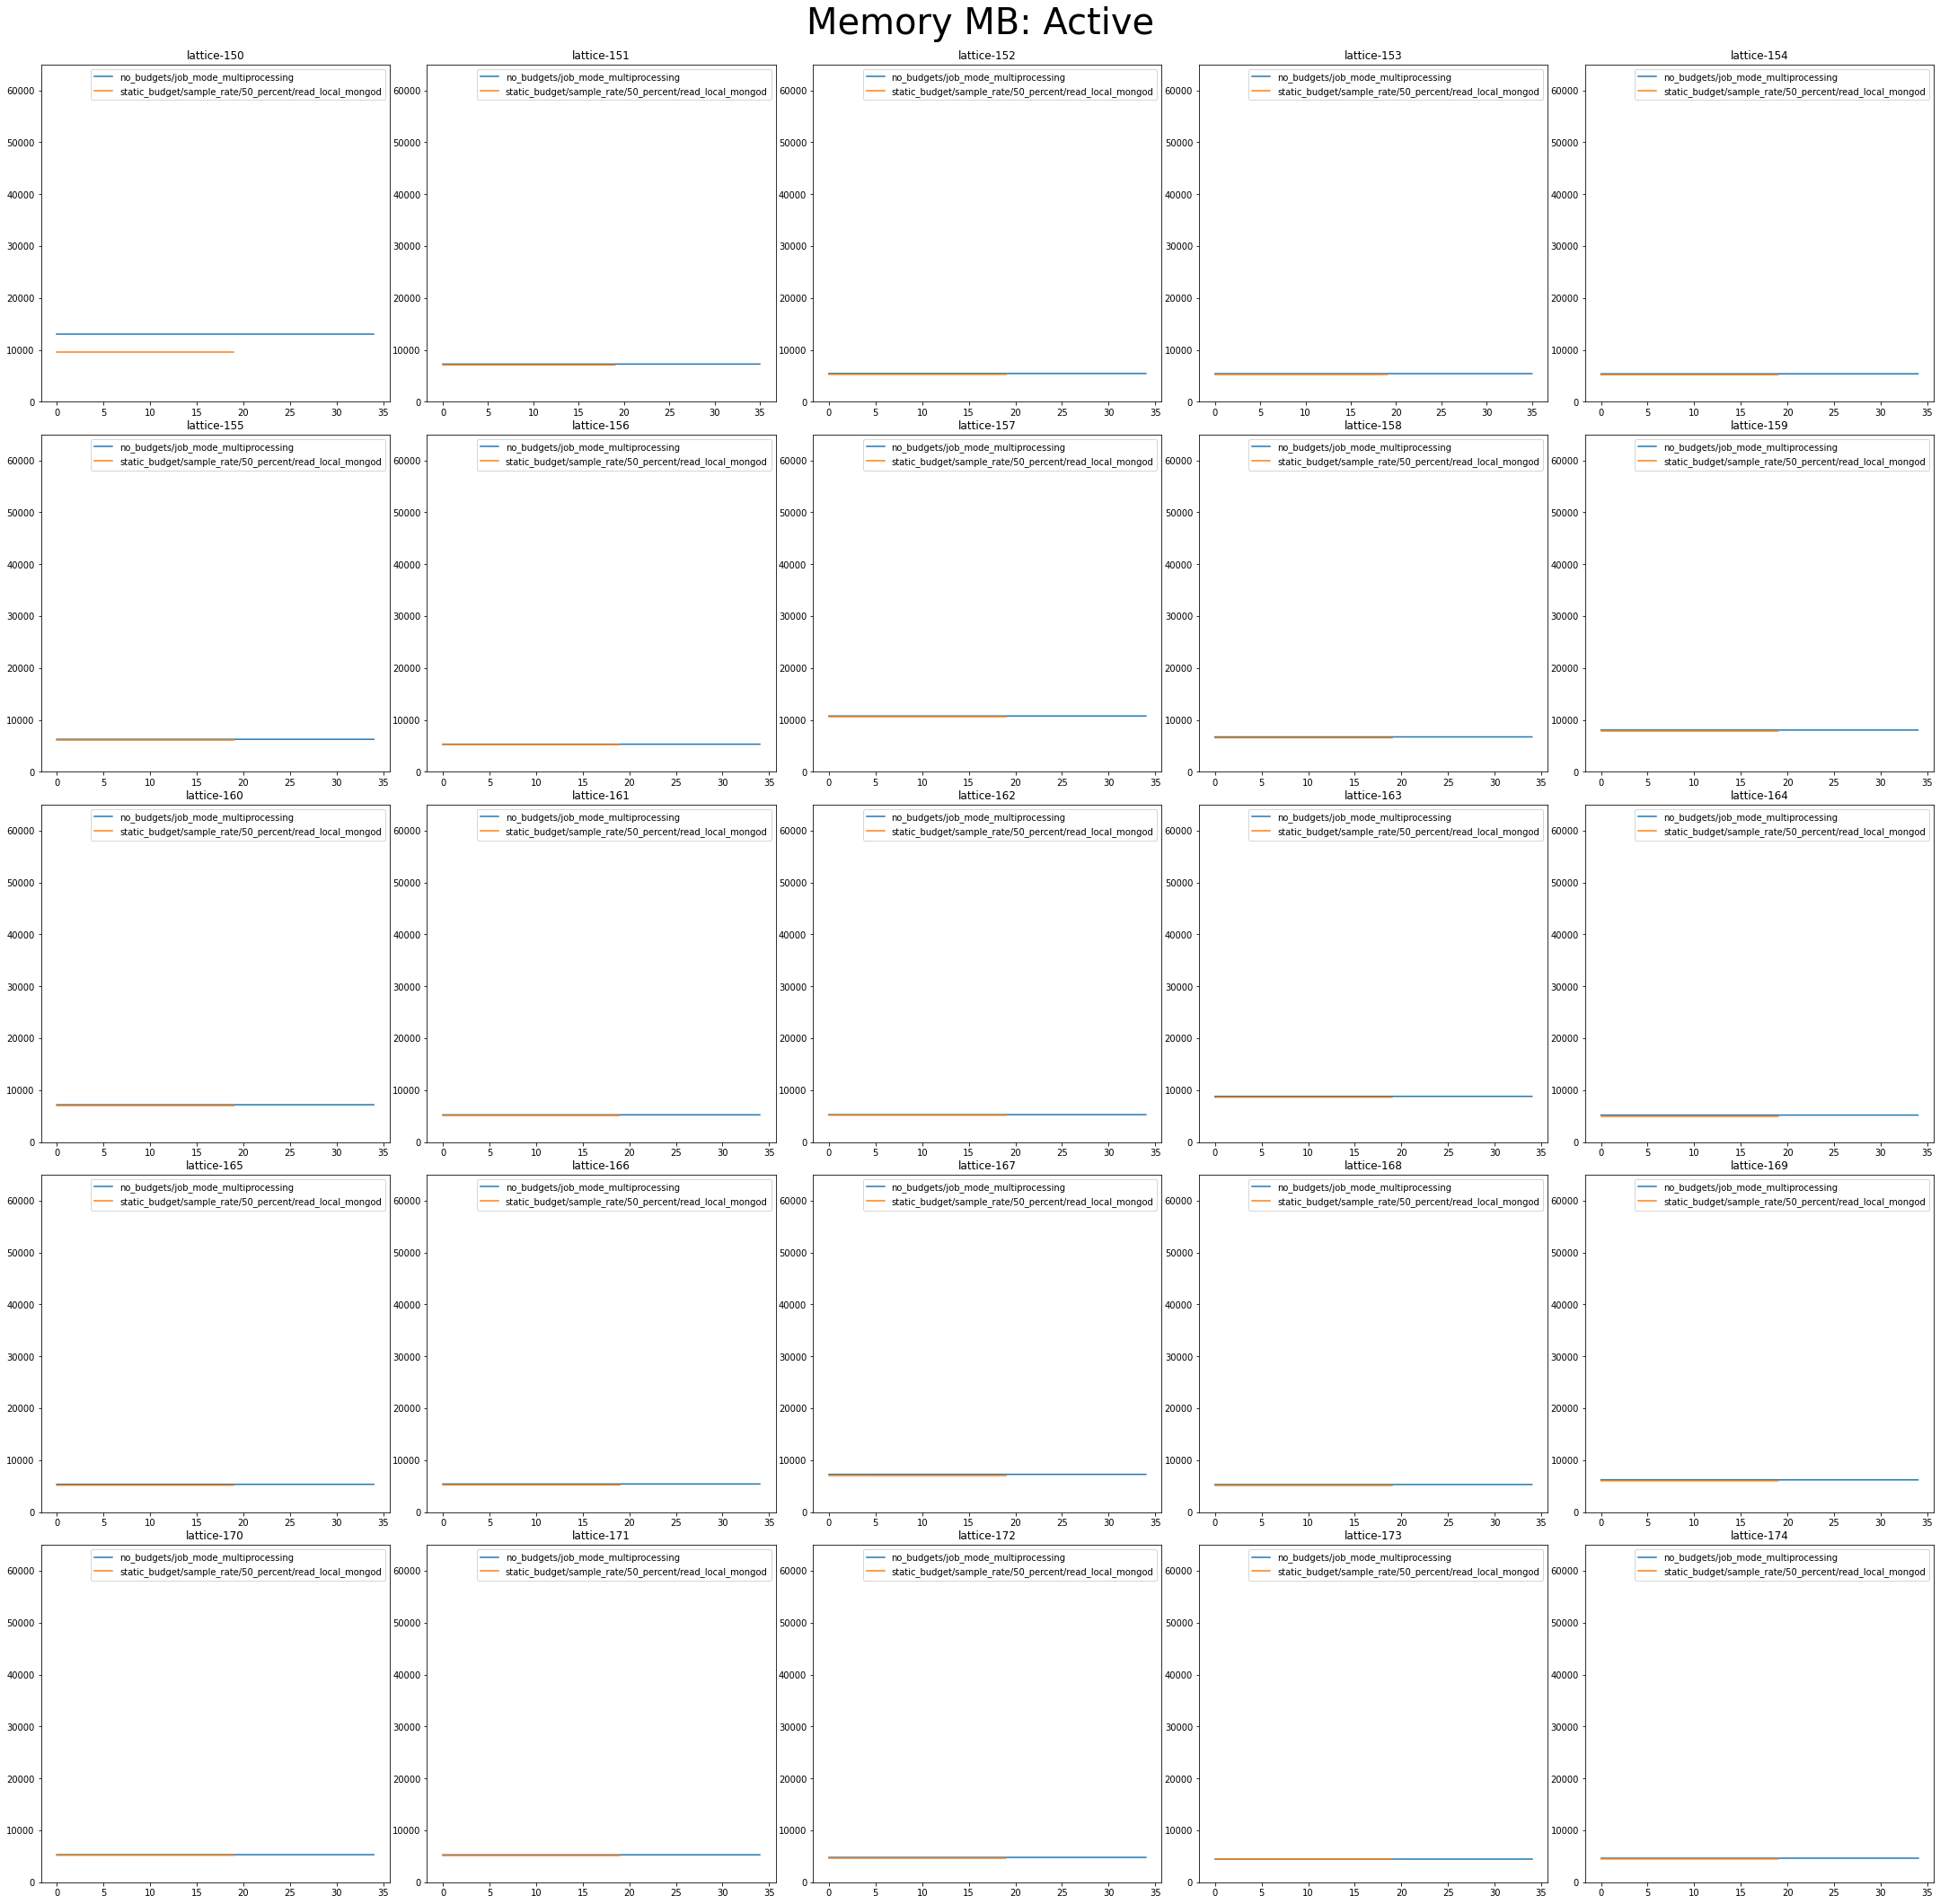

In [9]:
number_rows = 5
number_cols = 5

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(30, 30))
fig.tight_layout(h_pad=1.7)
fig.suptitle(metric_name, fontsize=40)

index = 0
for i in range(number_rows):
    for j in range(number_cols):
        for experiment, dataframe in experiment_dfs:
            ax[i,j].set_ylim(y_axis_limits)
            ax[i,j].plot(dataframe[index], label=experiment)
            ax[i,j].set_title(f"lattice-{150+index}")
            ax[i,j].legend()
        index += 1

plt.subplots_adjust(top=0.95)
plt.savefig('./cluster_statistics.png')

### Response Plotting

In [10]:
responses = []

for experiment in experiments:
    response_filename = f"{experiment}/response.json"
    with open(response_filename, "r") as response_file:
        responses.append((experiment, json.load(response_file)))

gis_join_count_filename = "../overlay/resources/gis_join_counts.json"

with open(gis_join_count_filename, "r") as f:
    gis_join_counts = json.load(f)

all_worker_counts = []
all_worker_durations = []
all_individual_durations = []
all_losses = []
all_variances = []

for experiment, response in responses:
    print(f"Total response duration for {experiment}: {response['duration_sec']} seconds")

    worker_durations = []
    worker_counts = []
    individual_durations = []
    individual_losses = []
    individual_variances = []
    for worker_response in response["worker_responses"]:
        worker_counts.append((worker_response["hostname"], len(worker_response["metrics"])))
        worker_durations.append((worker_response["hostname"], worker_response["duration_sec"]))
        for individual_metric in worker_response["metrics"]:
            if "duration_sec" in individual_metric.keys():
                individual_durations.append((individual_metric["gis_join"], individual_metric["duration_sec"]))
                individual_losses.append((individual_metric["gis_join"], individual_metric["loss"]))
                individual_variances.append((individual_metric["gis_join"], individual_metric["variance"]))

    individual_durations.sort(key=lambda y: y[0])
    all_individual_durations.append((experiment, [x[1] for x in individual_durations]))
    individual_losses.sort(key=lambda y: y[0])
    all_losses.append((experiment, [x[1] for x in individual_losses]))
    individual_variances.sort(key=lambda y: y[0])
    all_variances.append((experiment, [x[1] for x in individual_variances]))

    worker_durations.sort(key=lambda y: y[0])
    worker_durations_vals = [x[1] for x in worker_durations]
    worker_durations_names = [x[0][-3:] for x in worker_durations]
    all_worker_durations.append((experiment, worker_durations_names, worker_durations_vals))

    worker_counts.sort(key=lambda y: y[0])
    worker_counts_vals = [x[1] for x in worker_counts]
    worker_counts_names = [x[0][-3:] for x in worker_counts]
    all_worker_counts.append((experiment, worker_counts_names, worker_counts_vals))

number_rows = 6
number_cols = 1

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(24, 30))
fig.tight_layout(h_pad=1.9)
fig.suptitle("Response/Dataset Statistics", fontsize=40)
bar_width = 1.0/len(experiments) - 0.1

idx = 0
for worker_durations in all_worker_durations:
    x_axis = np.arange(len(worker_durations[1]))
    ax[0].bar(x_axis + idx * bar_width, worker_durations[2], width=bar_width, label=worker_durations[0])
    idx += 1
ax[0].set_title(f"Worker Durations")
ax[0].legend(loc="upper right")

idx = 0
for worker_counts in all_worker_counts:
    x_axis = np.arange(len(worker_counts[1]))
    ax[1].bar(x_axis + idx * bar_width, worker_counts[2], width=bar_width, label=worker_counts[0])
    idx += 1
ax[1].set_title(f"Worker Counts")
ax[1].legend(loc="upper right")

ax[2].set_title(f"GISJOIN Record Counts")
ax[2].plot(gis_join_counts.values(), '.')

for individual_durations in all_individual_durations:
    ax[3].plot(individual_durations[1], '.', label=individual_durations[0])
ax[3].set_title(f"Individual Durations")
ax[3].legend(loc="upper right")

for individual_losses in all_losses:
    ax[4].plot(individual_losses[1], '.', label=individual_losses[0])
ax[4].set_title(f"Individual Losses")
ax[4].legend(loc="upper right")

for individual_variances in all_variances:
    ax[4].plot(individual_variances[1], '.', label=individual_variances[0])
ax[4].set_title(f"Individual Variances")
ax[4].legend(loc="upper right")

plt.subplots_adjust(top=0.92)

plt.savefig('response_dataset_statistics.png')

Total response duration for no_budgets/job_mode_multiprocessing: 31.727867193054408 seconds
Total response duration for static_budget/sample_rate/50_percent/read_local_mongod: 16.64291350892745 seconds


KeyError: 'variance'